# CE-40719: Deep Learning
## HW5_Q7: VAE and CVAE 

#### Name: Sayed Hesam Alavian


# 1) Import Libraries and dataset and set to GPU

In [1]:
import numpy as np
import torch
import torch.nn as nn
import tqdm
import torch.optim as optim
import torch.nn.functional as F
from collections import OrderedDict
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# MNIST Dataset
train_data = datasets.MNIST(root='../../Datasets', train=True, download=True, transform=transforms.ToTensor())
train_iter = torch.utils.data.DataLoader(train_data, batch_size=512, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../../Datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../../Datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../../Datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../../Datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../../Datasets/MNIST/raw



In [3]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#define Classes for Models:

In [4]:
##### for convert data to 1 dim
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [5]:
####### Multilayer Perceptron
class MLP(nn.Module):
    def __init__(self, hidden_size, last_activation = True):
        super(MLP, self).__init__()
        q = []
        for i in range(len(hidden_size)-1):
            in_dim = hidden_size[i]
            out_dim = hidden_size[i+1]
            q.append(("Linear_%d" % i, nn.Linear(in_dim, out_dim)))
            if (i < len(hidden_size)-2) or ((i == len(hidden_size) - 2) and (last_activation)):
                q.append(("BatchNorm_%d" % i, nn.BatchNorm1d(out_dim)))
                q.append(("ReLU_%d" % i, nn.ReLU(inplace=True)))
        self.mlp = nn.Sequential(OrderedDict(q))
    def forward(self, x):
        return self.mlp(x)

##Encoder

In [17]:
class Encoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Encoder, self).__init__()
        c, h, w = shape
        ww = ((w-8)//2 - 4)//2
        hh = ((h-8)//2 - 4)//2
        self.encode = nn.Sequential(
            nn.Conv2d(c, 16, 5, padding = 0),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(inplace = True),

            nn.Conv2d(16, 32, 5, padding = 0),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace = True),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, 3, padding = 0),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(inplace = True),

            nn.Conv2d(64, 64, 3, padding = 0),
            nn.BatchNorm2d(64), nn.ReLU(inplace = True),  
            nn.MaxPool2d(2, 2),
            Flatten(), MLP([ww*hh*64, 256, 128])
        )
        self.calc_mean = MLP([128+ncond, 64, nhid], last_activation = False)
        self.calc_logvar = MLP([128+ncond, 64, nhid], last_activation = False)
    def forward(self, x, y = None):
        x = self.encode(x)
        if (y is None):
            return self.calc_mean(x), self.calc_logvar(x)
        else:
            return self.calc_mean(torch.cat((x, y), dim=1)), self.calc_logvar(torch.cat((x, y), dim=1))

In [7]:
class Decoder(nn.Module):
    def __init__(self, shape, nhid = 16, ncond = 0):
        super(Decoder, self).__init__()
        c, w, h = shape
        self.shape = shape
        self.decode = nn.Sequential(
            MLP([nhid+ncond, 64, 128, 256, c*w*h],
            last_activation = False),
            nn.Sigmoid()
            )
    def forward(self, z, y = None):
        c, w, h = self.shape
        if (y is None):
            return self.decode(z).view(-1, c, w, h)
        else:
            return self.decode(torch.cat((z, y), dim=1)).view(-1, c, w, h)

In [8]:
class VAE(nn.Module):
    def __init__(self, shape, nhid = 16):
        super(VAE, self).__init__()
        self.dim = nhid
        self.encoder = Encoder(shape, nhid)
        self.decoder = Decoder(shape, nhid)
        
    def sampling(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma
    
    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.sampling(mean, logvar)
        return self.decoder(z), mean, logvar
    
    def generate(self, batch_size = None):
        z = torch.randn((batch_size, self.dim)).to(device) if batch_size else torch.randn((1, self.dim)).to(device)
        res = self.decoder(z)
        if not batch_size:
            res = res.squeeze(0)
        return res

In [9]:
class cVAE(nn.Module):
    def __init__(self, shape, nclass, nhid = 16, ncond = 16):
        super(cVAE, self).__init__()
        self.dim = nhid
        self.encoder = Encoder(shape, nhid, ncond = ncond)
        self.decoder = Decoder(shape, nhid, ncond = ncond)
        self.label_embedding = nn.Embedding(nclass, ncond)
        
    def sampling(self, mean, logvar):
        eps = torch.randn(mean.shape).to(device)
        sigma = 0.5 * torch.exp(logvar)
        return mean + eps * sigma
    
    def forward(self, x, y):
        y = self.label_embedding(y)
        mean, logvar = self.encoder(x, y)
        z = self.sampling(mean, logvar)
        return self.decoder(z, y), mean, logvar
    
    def generate(self, class_idx):
        if (type(class_idx) is int):
            class_idx = torch.tensor(class_idx)
        class_idx = class_idx.to(device)
        if (len(class_idx.shape) == 0):
            batch_size = None
            class_idx = class_idx.unsqueeze(0)
            z = torch.randn((1, self.dim)).to(device)
        else:
            batch_size = class_idx.shape[0]
            z = torch.randn((batch_size, self.dim)).to(device) 
        y = self.label_embedding(class_idx)
        res = self.decoder(z, y)
        if not batch_size:
            res = res.squeeze(0)
        return res

In [10]:
BCE_loss = nn.BCELoss(reduction = "sum")
def loss(X, X_hat, mean, logvar):
    reconstruction_loss = BCE_loss(X_hat, X)
    KL_divergence = 0.5 * torch.sum(-1 - logvar + torch.exp(logvar) + mean**2)
    return reconstruction_loss + KL_divergence

In [11]:
# Hyperparameters
n_epochs = 25
lr = 0.01

In [18]:
vae = VAE((1, 28, 28), nhid = 4)
vae.to(device)
print(vae)

VAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): LeakyReLU(negative_slope=0.01, inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, paddin

In [ ]:
optimizer = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay = 0.0001)

for epoch in range(n_epochs):
    train_loss, n = 0.0, 0
    for X, _ in tqdm.tqdm(train_iter, ncols = 50):
        X = X.to(device)
        X_hat, mean, logvar = vae(X)

        l = loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    print('epoch %d, train loss %.4f' % (epoch, train_loss))

100%|███████████| 118/118 [00:14<00:00,  8.10it/s]


epoch 0, train loss 153.5486


100%|███████████| 118/118 [00:14<00:00,  8.09it/s]


epoch 1, train loss 127.3906


100%|███████████| 118/118 [00:14<00:00,  8.12it/s]


epoch 2, train loss 123.5556


100%|███████████| 118/118 [00:14<00:00,  8.14it/s]


epoch 3, train loss 121.1247


100%|███████████| 118/118 [00:14<00:00,  8.21it/s]


epoch 4, train loss 119.8340


100%|███████████| 118/118 [00:14<00:00,  8.08it/s]


epoch 5, train loss 118.4194


100%|███████████| 118/118 [00:14<00:00,  8.16it/s]


epoch 6, train loss 117.6480


100%|███████████| 118/118 [00:14<00:00,  8.14it/s]


epoch 7, train loss 116.4853


100%|███████████| 118/118 [00:14<00:00,  8.08it/s]


epoch 8, train loss 116.2005


100%|███████████| 118/118 [00:14<00:00,  8.13it/s]


epoch 9, train loss 115.6316


100%|███████████| 118/118 [00:14<00:00,  8.13it/s]


epoch 10, train loss 115.0370


100%|███████████| 118/118 [00:14<00:00,  8.08it/s]


epoch 11, train loss 114.9278


100%|███████████| 118/118 [00:14<00:00,  8.12it/s]


epoch 12, train loss 114.5830


100%|███████████| 118/118 [00:14<00:00,  8.11it/s]


epoch 13, train loss 113.8736


100%|███████████| 118/118 [00:14<00:00,  8.22it/s]


epoch 14, train loss 113.9217


100%|███████████| 118/118 [00:14<00:00,  8.17it/s]


epoch 15, train loss 113.2826


100%|███████████| 118/118 [00:14<00:00,  8.18it/s]


epoch 16, train loss 112.9821


100%|███████████| 118/118 [00:14<00:00,  8.19it/s]


epoch 17, train loss 113.2670


100%|███████████| 118/118 [00:14<00:00,  8.15it/s]


epoch 18, train loss 112.9187


100%|███████████| 118/118 [00:14<00:00,  8.29it/s]


epoch 19, train loss 112.5398


100%|███████████| 118/118 [00:14<00:00,  8.29it/s]


epoch 20, train loss 112.2798


100%|███████████| 118/118 [00:14<00:00,  8.24it/s]


epoch 21, train loss 112.0813


100%|███████████| 118/118 [00:14<00:00,  8.22it/s]


epoch 22, train loss 112.1065


100%|███████████| 118/118 [00:14<00:00,  8.25it/s]


epoch 23, train loss 111.8869


100%|███████████| 118/118 [00:14<00:00,  8.24it/s]

epoch 24, train loss 111.6036


fake images


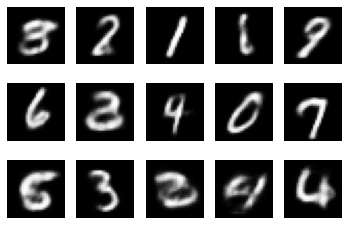

In [ ]:
with torch.no_grad():
    x = vae.generate(batch_size=15)
    
print("fake images")
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.imshow(x[i].squeeze(0).cpu().numpy(), cm.gray)

In [ ]:
CVAE = cVAE((1, 28, 28), nclass = 10, nhid = 2, ncond = 16)
CVAE.to(device)

cVAE(
  (encoder): Encoder(
    (encode): Sequential(
      (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (8): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (14): Flatten()
      (15): MLP(
    

In [ ]:
def adjust_lr(optimizer, decay_rate=0.95):
    for param_group in optimizer.param_groups:
        param_group['lr'] *= decay_rate

optimizer = torch.optim.Adam(CVAE.parameters(), lr=lr, weight_decay = 0.0001)

for epoch in range(n_epochs):
    train_loss, n = 0.0, 0
    for X, y in tqdm.tqdm(train_iter, ncols = 50):
        X = X.to(device)
        y = y.to(device)
        X_hat, mean, logvar = CVAE(X, y)

        l = loss(X, X_hat, mean, logvar).to(device)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()

        train_loss += l.cpu().item()
        n += X.shape[0]

    train_loss /= n
    print('epoch %d, train loss %.4f' % (epoch, train_loss))

    adjust_lr(optimizer)

100%|███████████| 118/118 [00:08<00:00, 14.05it/s]


epoch 0, train loss 160.6788


100%|███████████| 118/118 [00:08<00:00, 14.35it/s]


epoch 1, train loss 134.3928


100%|███████████| 118/118 [00:08<00:00, 13.97it/s]


epoch 2, train loss 131.6470


100%|███████████| 118/118 [00:08<00:00, 14.42it/s]


epoch 3, train loss 130.5856


100%|███████████| 118/118 [00:08<00:00, 14.63it/s]


epoch 4, train loss 129.5687


100%|███████████| 118/118 [00:08<00:00, 14.64it/s]


epoch 5, train loss 128.8259


100%|███████████| 118/118 [00:08<00:00, 14.45it/s]


epoch 6, train loss 128.2981


100%|███████████| 118/118 [00:07<00:00, 14.80it/s]


epoch 7, train loss 127.7659


100%|███████████| 118/118 [00:08<00:00, 14.58it/s]


epoch 8, train loss 127.4931


100%|███████████| 118/118 [00:08<00:00, 14.64it/s]


epoch 9, train loss 127.0700


100%|███████████| 118/118 [00:08<00:00, 14.64it/s]


epoch 10, train loss 126.7565


100%|███████████| 118/118 [00:08<00:00, 14.63it/s]


epoch 11, train loss 126.3834


100%|███████████| 118/118 [00:08<00:00, 14.59it/s]


epoch 12, train loss 126.2308


100%|███████████| 118/118 [00:08<00:00, 14.59it/s]


epoch 13, train loss 125.8422


100%|███████████| 118/118 [00:08<00:00, 14.56it/s]


epoch 14, train loss 125.7888


100%|███████████| 118/118 [00:08<00:00, 14.47it/s]


epoch 15, train loss 125.4668


100%|███████████| 118/118 [00:08<00:00, 14.67it/s]


epoch 16, train loss 125.4519


100%|███████████| 118/118 [00:08<00:00, 14.57it/s]


epoch 17, train loss 125.1556


100%|███████████| 118/118 [00:08<00:00, 14.38it/s]


epoch 18, train loss 124.8071


100%|███████████| 118/118 [00:08<00:00, 14.58it/s]


epoch 19, train loss 124.6290


100%|███████████| 118/118 [00:08<00:00, 14.57it/s]


epoch 20, train loss 124.5771


100%|███████████| 118/118 [00:08<00:00, 14.58it/s]


epoch 21, train loss 124.5835


100%|███████████| 118/118 [00:08<00:00, 14.23it/s]


epoch 22, train loss 124.2022


100%|███████████| 118/118 [00:08<00:00, 14.44it/s]


epoch 23, train loss 124.0279


100%|███████████| 118/118 [00:08<00:00, 14.49it/s]

epoch 24, train loss 123.8945


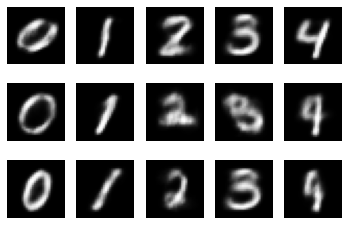

In [ ]:
with torch.no_grad():
    x = CVAE.generate(torch.tensor([list(range(5))] * 3).clone().view(-1))
    
for i in range(15):
    plt.subplot(3, 5, i+1)
    plt.axis("off")
    plt.imshow(x[i].squeeze(0).cpu().numpy(), cm.gray)